In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pennylane import numpy as np
import torch

## Imports
import os
import sys
import matplotlib.pyplot as plt


In [3]:
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), "./"))

if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from src.utils.logger import Logging
from src.poisson.dv_solver import DVPDESolver
from src.poisson.cv_solver import CVPDESolver
from src.nn.pde import wave_operator
from src.utils.plot_prediction import plt_prediction
from src.data.wave_dataset import u, r
import src.poisson.wave_train as wave_train
from src.poisson.classical_solver import Classical_Solver
from src.data.wave_dataset import Sampler


os.environ['CUDA_VISIBLE_DEVICES'] = '-1'    # for no GPUs


/okyanus/users/afarea/anaconda3_2021/envs/pennylane_env/lib/python3.9/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 8000). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [4]:
DEVICE = 'cpu'
# Define PINN model
a = torch.tensor(0.5, dtype=torch.float32, device=DEVICE)
c = torch.tensor(2.0, dtype=torch.float32, device=DEVICE)

kernel_size = 300

# Domain boundaries - convert to float32
ics_coords = np.array([[0.0, 0.0], [0.0, 1.0]], dtype=np.float32)
bc1_coords = np.array([[0.0, 0.0], [1.0, 0.0]], dtype=np.float32)
bc2_coords = np.array([[0.0, 1.0], [1.0, 1.0]], dtype=np.float32)
dom_coords = np.array([[0.0, 0.0], [1.0, 1.0]], dtype=np.float32)

# Create initial conditions samplers
ics_sampler = Sampler(2, ics_coords, lambda x: u(x, a, c), device=DEVICE)

# Create boundary conditions samplers
bc1 = Sampler(2, bc1_coords, lambda x: u(x, a, c), device=DEVICE)
bc2 = Sampler(2, bc2_coords, lambda x: u(x, a, c), device=DEVICE)
bcs_sampler = [bc1, bc2]

# Create residual sampler
res_sampler = Sampler(2, dom_coords, lambda x: r(x, a, c), device=DEVICE)
coll_sampler = Sampler(2, dom_coords, lambda x: u(x, a, c), device=DEVICE)

# Create mesh grid with float32
number_of_points = 10
t = np.linspace(dom_coords[0, 0], dom_coords[1, 0], number_of_points, dtype=np.float32)[:, None]
x = np.linspace(dom_coords[0, 1], dom_coords[1, 1], number_of_points, dtype=np.float32)[:, None]
t, x = np.meshgrid(t, x)

# Convert to PyTorch tensor with float32
X_star = torch.hstack((
    torch.from_numpy(t.flatten()[:, None]), 
    torch.from_numpy(x.flatten()[:, None])
)).to(DEVICE).to(torch.float32)



In [5]:

mode = "hybrid"
num_qubits = 5
output_dim = 1
input_dim = 2
hidden_dim = 50
num_quantum_layers = 1
cutoff_dim = 10
classic_network = [input_dim, hidden_dim, output_dim]



args = {
    "batch_size": 64,
    "epochs": 20000,
    "lr": 0.005,
    "seed": 1,
    "print_every": 1000,
    "log_path": "./checkpoints/wave",
    "input_dim": input_dim,
    "output_dim": output_dim,
    "num_qubits": num_qubits,
    "hidden_dim": hidden_dim,
    "num_quantum_layers": num_quantum_layers,
    "classic_network": classic_network,
    "q_ansatz": "sim_circ_19",  # options: "alternating_layer_tdcnot", "abbas" , farhi , sim_circ_13_half, sim_circ_13 , sim_circ_14_half, sim_circ_14 , sim_circ_15 ,sim_circ_19
    "mode": mode,
    "activation": "tanh",  # options: "null", "partial_measurement_half" , partial_measurement_x
    "shots": None,  # Analytical gradients enabled
    "problem": "wave",
    "solver": "Classical",  # options : "CV", "Classical", "DV"
    "device": DEVICE,
    "method": "None",
    "cutoff_dim": cutoff_dim,  # num_qubits >= cutoff_dim
    "class": "Classical",  # options : "DVQuantumLayer", GSRandomCVQNN , "CVQuantumLayer", "Enhanced_CVQuantumLayer"
    "encoding": "angle", # options angle , amplitude
}


In [6]:
log_path = args["log_path"]
logger = Logging(log_path)

In [7]:

if args["solver"] == "CV":
    model = CVPDESolver(args, logger, X_star, DEVICE)
    model.logger.print("Using CV Solver")
elif args["solver"] == "Classical":
    model = Classical_Solver(args, logger, X_star, DEVICE)
    model.logger.print("Using Classical Solver")
else:
    model = DVPDESolver(args, logger, X_star, DEVICE)
    model.logger.print("Using DV Solver")
# Training loop
model.logger.print(f"The settings used:")
for key, value in args.items():
    model.logger.print(f"{key} : {value}")



# Print total number of parameters
total_params = sum(p.numel() for p in model.parameters())
model.logger.print(f"Total number of parameters: {total_params}")


INFO:src.utils.logger:checkpoint path: self.log_path='./checkpoints/wave/2025-02-24_15-08-48-412453'
INFO:src.utils.logger:Using Classical Solver
INFO:src.utils.logger:The settings used:
INFO:src.utils.logger:batch_size : 64
INFO:src.utils.logger:epochs : 20000
INFO:src.utils.logger:lr : 0.005
INFO:src.utils.logger:seed : 1
INFO:src.utils.logger:print_every : 1000
INFO:src.utils.logger:log_path : ./checkpoints/wave
INFO:src.utils.logger:input_dim : 2
INFO:src.utils.logger:output_dim : 1
INFO:src.utils.logger:num_qubits : 5
INFO:src.utils.logger:hidden_dim : 50
INFO:src.utils.logger:num_quantum_layers : 1
INFO:src.utils.logger:classic_network : [2, 50, 1]


INFO:src.utils.logger:q_ansatz : sim_circ_19
INFO:src.utils.logger:mode : hybrid
INFO:src.utils.logger:activation : tanh
INFO:src.utils.logger:shots : None
INFO:src.utils.logger:problem : wave
INFO:src.utils.logger:solver : Classical
INFO:src.utils.logger:device : cpu
INFO:src.utils.logger:method : None
INFO:src.utils.logger:cutoff_dim : 10
INFO:src.utils.logger:class : Classical
INFO:src.utils.logger:encoding : angle
INFO:src.utils.logger:Total number of parameters: 2751


In [8]:
wave_train.train(model)


INFO:src.utils.logger:It: 0, Loss: 3.874e+00, Loss_res: 3.848e-03,  Loss_bcs: 8.607e-03, Loss_ut_ics: 2.081e-03, lr: 5.000e-03, Time: 2.55e-02
INFO:src.utils.logger:Model state saved to ./checkpoints/wave/2025-02-24_15-08-48-412453/model.pth


INFO:src.utils.logger:It: 1000, Loss: 1.029e+00, Loss_res: 2.375e-02,  Loss_bcs: 1.963e-02, Loss_ut_ics: 1.699e-02, lr: 5.000e-03, Time: 3.57e-03
INFO:src.utils.logger:Model state saved to ./checkpoints/wave/2025-02-24_15-08-48-412453/model.pth
INFO:src.utils.logger:It: 2000, Loss: 9.485e-01, Loss_res: 3.586e-02,  Loss_bcs: 1.383e-02, Loss_ut_ics: 3.072e-02, lr: 5.000e-03, Time: 3.55e-03
INFO:src.utils.logger:Model state saved to ./checkpoints/wave/2025-02-24_15-08-48-412453/model.pth


KeyboardInterrupt: 

## Plot loss history

In [ ]:


# Print total number of parameters
total_params = sum(p.numel() for p in model.parameters())

model.logger.print(f"Total number of parameters: {total_params}")


INFO:src.utils.logger:Total number of parameters: 776


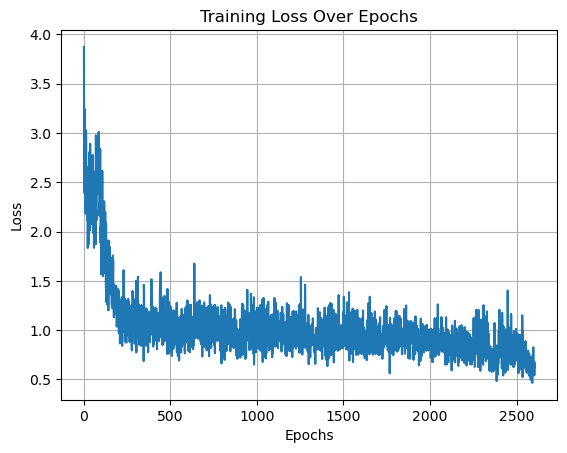

In [9]:
plt.plot(range(len(model.loss_history)), model.loss_history)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.grid()

file_path = os.path.join(model.log_path, "loss_history.pdf")
plt.savefig(file_path, bbox_inches="tight")
plt.show()

plt.close(
    "all",
)

# Testing


In [10]:


DEVICE = 'cpu'
# Define PINN model
a = torch.tensor(0.7, dtype=torch.float32, device=DEVICE)
c = torch.tensor(2.0, dtype=torch.float32, device=DEVICE)

dom_coords = np.array([[0.0, 0.0], [1.0, 1.0]], dtype=np.float32)



# Create mesh grid with float32
number_of_points = 10
t = np.linspace(dom_coords[0, 0], dom_coords[1, 0], number_of_points, dtype=np.float32)[:, None]
x = np.linspace(dom_coords[0, 1], dom_coords[1, 1], number_of_points, dtype=np.float32)[:, None]
t, x = np.meshgrid(t, x)

# Convert to PyTorch tensor with float32
X_star = torch.hstack((
    torch.from_numpy(t.flatten()[:, None]), 
    torch.from_numpy(x.flatten()[:, None])
)).to(DEVICE).to(torch.float32)

u_star = u(X_star, a, c)
f_star = r(X_star, a, c)

# Predictions
u_pred_star, f_pred_star = wave_operator(model, X_star[:, 0:1], X_star[:, 1:2])

u_pred = u_pred_star.cpu().detach().numpy()
f_pred = f_pred_star.cpu().detach().numpy()
u_star = u_star.cpu().detach().numpy()
f_star = f_star.cpu().detach().numpy()
X = X_star.cpu().detach().numpy()


# Relative L2 error
error_u = np.linalg.norm(u_pred - u_star) / np.linalg.norm(u_star) * 100
error_f = np.linalg.norm(f_pred - f_star) / np.linalg.norm(f_star) * 100

logger.print("Relative L2 error_u: {:.2e}".format(error_u))
logger.print("Relative L2 error_f: {:.2e}".format(error_f))




/tmp/ipykernel_171067/4239897817.py:37: RuntimeWarning: divide by zero encountered in scalar divide
  error_f = np.linalg.norm(f_pred - f_star) / np.linalg.norm(f_star) * 100
INFO:src.utils.logger:Relative L2 error_u: 9.15e+01
INFO:src.utils.logger:Relative L2 error_f: inf


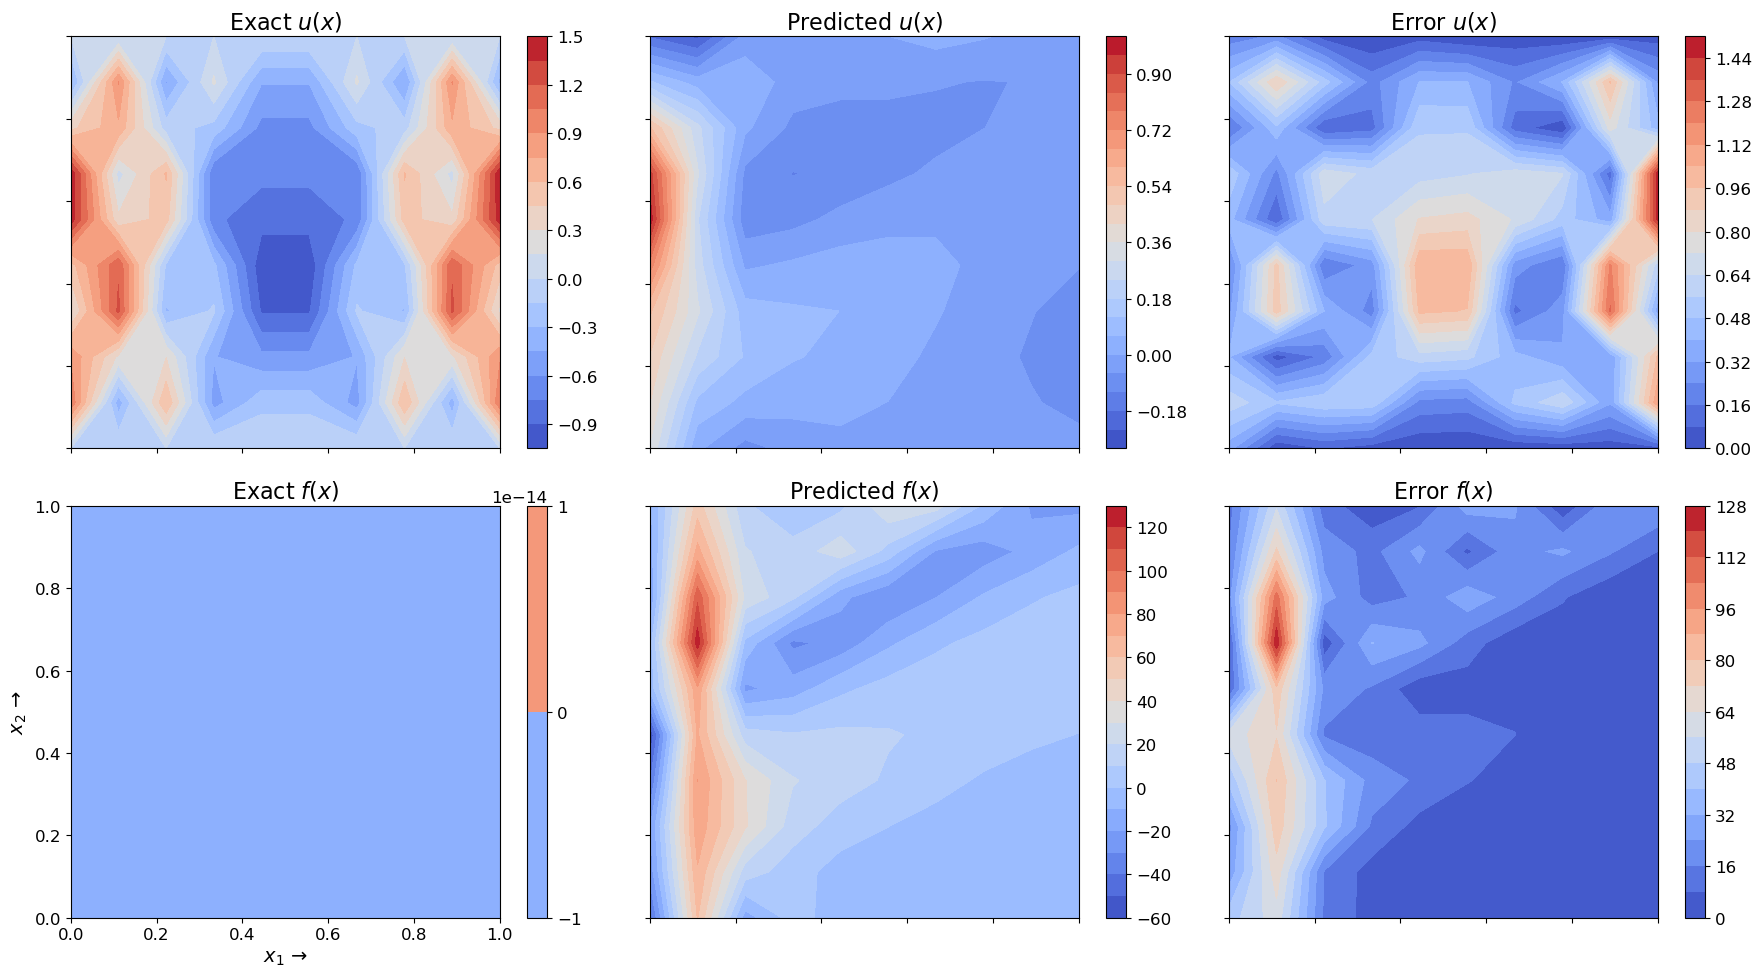

In [11]:

# Plot predictions
plt_prediction(
    logger,
    X,
    u_star,
    u_pred,
    f_star,
    f_pred,
)